# X-Ray Diffractions Detector
> A Multi-Label Image Classification

- comments: true
- toc: true
- badges: true
- categories: [image-classifer, fastai2]

This program is try to do something that I have no idea to detect if it is even distantly correct. I was able to find a peculiar dataset called X-Ray Defraction Imageset thanks to Czyzewski et. al. The imageset was downloaded for traning the dataset from the link available [here](https://zenodo.org/record/2605120#.XqAU3nVfg5m). I love to try out something new as a hobby and see how it works out to be.

Czyzewski, Adam, Krawiec, Faustyna, Brzezinski, Dariusz, & Porebski, Przemyslaw J. (2019). RefleX: X-ray diffraction images dataset (Version 1.0.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.2605120

X-Ray Defraction Imageset from [here](https://zenodo.org/record/2605120#.XpcIN3Vfg5l)

## Tracking Experiments

Now we are going to explore options on how to get our accuracy high enough. We have various tools that track the experiments that were done. Having such things help us to understand what hyper parameters to choose and get intutions on what experiments to try. 

We are going to use [WandB](https://www.wandb.com) which is one amoung the top tools used.

I may use this for klogging my experiments. However, Since the one that gave the best result is shown below, its trivial if you use WandB and WandBCallback.

In [1]:
#collapse
import os
os.environ['WANDB_BASE_URL'] = 'http://localhost:8080'
from fastai2.callback.wandb import wandb,WandbCallback

## Extract Data

If you havent extracted the zip file, the first step might be to extract it. The extraction can be manual or can be done using Python

In [2]:
#hide
from zipfile import ZipFile
with ZipFile('zip_file_location', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(Path("../../data/Multi-label/images"))

## Setup the notebook

The first step might be to setup the notebook and set path correctly. This will remove all possible hindrences on later.

Lets just import the required libraries from `fastai2`. As it is a vision task we shall try importing `fastai2.vision`

Also the file that maps the labels to the images is a CSV. we know `pandas` is good at tabular data and is the most convinent way to handle CSV data. So, we include that as well

In [2]:
from fastai2.vision.all import *
from fastai2.vision.widgets import *
import pandas as pd 

We create `path` variable to be pointing to the location wherever it is downloaded

In [3]:
#collapse
path=Path("../../data/Multi-label/")
Path.BASE_PATH = path

>`Path` from `pathlib` by itself doesn't have a convenience function to list all child files/folders. we may have to actually do `list(path.iterdir())` to get that. Fast-AI however has made a convenient function `.ls()` that gets overloaded as we import the library  

In [4]:
files=path.ls()
files

(#3) [Path('images'),Path('labels.csv'),Path('reflex_img_1024_inter_nearest.zip')]

Here we see that the images are available in the `images` folder and the label-image mapping is done in `labels.csv`. The original downloaded zip file is the other `reflex_img_1024_inter_nearest.zip` file that is available. However it is never used in this program

## Analysis

I have no idea how the data is in the CSV or image. Lets just load the data and have a look at it

In [5]:
labels_df=pd.read_csv(path/'labels.csv')
labels_df

,image,loop_scattering,background_ring,strong_background,diffuse_scattering,artifact,ice_ring,non_uniform_detector
0,152803_2_0001,1,0,1,0,0,0,0
1,81258_1_E1_001,1,1,1,0,0,0,0
2,HMCb11_AY6-7_00001,0,1,1,0,1,0,0
3,195706_1_E2_00001,0,0,0,0,1,1,0
4,nui1-10_1_001,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
6306,wjm1-6,0,1,0,0,0,0,0
6307,xtal-C7-eg.0001,0,0,0,0,0,0,1
6308,AR1_IF0130_screen_0001,0,0,1,0,1,0,1
6309,215574f10_x0001,1,1,1,0,0,0,0


Now we see that the CSV has `image` as the first column and columns that representing the label as list of columns each reflecting 1 or 0 as in True or False.

There are totally 6311 samples. We also see that the number of columns available are 8. 1 input (Image file name) and the 7 probable classes.

## Data Munching

All the label columns are having values as 0 or 1. This is one of the ways to directly feed this as on-hot encoded vector to the model. But we may have inconvinence in interpreting 0 and 1 and mapping columns.

If we let `fastai2` do the `one-hot-encoding`, we may have some extra convience in interpreting the model output. So I prefer to have the labels as the actual string with comma seperation between those columns. I do that in the following steps.

- Get all label columns
- For each row, if the label is marked as present (i.e) value is 1, then add that to the string
- Add a new column `labels` with the label names of the ones that just exist

In [6]:
y_cols=list(labels_df.columns[1:])

In [7]:
def get_labels(row):
    return ', '.join([col for col in y_cols if row[col]==1])

In [8]:
labels_df['labels']=labels_df.apply(get_labels,axis=1)

We have made up a new column `labels` which lists the labels for that image. Lets see if we got it right

In [9]:
labels_df

,image,loop_scattering,background_ring,strong_background,diffuse_scattering,artifact,ice_ring,non_uniform_detector,labels
0,152803_2_0001,1,0,1,0,0,0,0,"loop_scattering, strong_background"
1,81258_1_E1_001,1,1,1,0,0,0,0,"loop_scattering, background_ring, strong_background"
2,HMCb11_AY6-7_00001,0,1,1,0,1,0,0,"background_ring, strong_background, artifact"
3,195706_1_E2_00001,0,0,0,0,1,1,0,"artifact, ice_ring"
4,nui1-10_1_001,1,1,1,0,0,0,0,"loop_scattering, background_ring, strong_background"
...,...,...,...,...,...,...,...,...,...
6306,wjm1-6,0,1,0,0,0,0,0,background_ring
6307,xtal-C7-eg.0001,0,0,0,0,0,0,1,non_uniform_detector
6308,AR1_IF0130_screen_0001,0,0,1,0,1,0,1,"strong_background, artifact, non_uniform_detector"
6309,215574f10_x0001,1,1,1,0,0,0,0,"loop_scattering, background_ring, strong_background"


There are 6311 rows. which means there should be atleast 6311 images in the file

In [10]:
len(Path(path/"images").ls())

6312

We have one more than required. Lets see if we have any non `.png` file or folders

In [11]:
Path(path/"images").ls().filter(lambda x: x.suffix!='.png')

(#1) [Path('images/models')]

Ok. There seems to be an empty models folder present in `images` folder.

Ok. Now lets look at random image

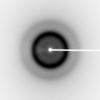

In [12]:
from random import randint
total_count=len(Path(path/"images").ls())-1 # Discount the models folder
index= randint(0,total_count)
image_paths=Path(path/"images").ls().filter(lambda x: x.suffix=='.png')
image_path=image_paths[index]
im = Image.open(image_path)
im.thumbnail((100,100))
im

Rerunning the above cell provides enough samples to get an idea of the dataset. Seems the dataset is grey scale

## Preparing the data

We need `DataLoaders` to point out the list of transformations that are to be done to the data for preparing for training. Luckily, we have `ImageDataLoaders.from_df` method to get an handy function for generating the dataloader. We use that here

There are couple of things to note on the decision of parameters:
- First parameter is the dataframe itself
-`label_col` is the column which has the list of labels
- `path` must specify the path where the images are stored
- `suff` is the suffix that must be added to all the filenames. In short the file extensions
- `label_delim` specifies the delimiter that segregates two labels apart (in the `label_col`
- `item_tfms` specifies the item level transformations that must be done. Here we are just doing resizing of original image to 224*224 image size. 

> The idea of using Squish to resize was because I am guessing cropping might remove some of the features. Especially after looking at some label names like `loop_scattering` , `non-uniform_detector` or `strong_background`. `loop_scattering` is fairly obvious there seems to be some disturbance in the rings which is that that obvious in the inner rings. cropping might not be that useful. 

Note: The Default augmentations are not added on purpose as brighness, contrast can affect the `strong_background` feature 

In [13]:
def generate_dataloaders( df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
            y_block=None,x_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
    "Create from `df` using `fn_col` and `label_col`"
    pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
    if y_block is None:
        is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
        y_block = MultiCategoryBlock if is_multi else CategoryBlock
    if x_block is None:
        x_block=ImageBlock
    splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
    dblock = DataBlock(blocks=(x_block, y_block),
                       get_x=ColReader(fn_col, pref=pref, suff=suff),
                       get_y=ColReader(label_col, label_delim=label_delim),
                       splitter=splitter,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)
    return DataLoaders.from_dblock(dblock, df, path=path, **kwargs)

In [ ]:
#hide
run_name='Basic Resnet 16 - 48 Pix - 32 Batch'
wandb.init(project='Multi-Class X-Ray Diffractions Detector', name=run_name,resume=True)

We now create the dataloader with this data frame:

* `x_block` might be the black and white monochrome image. 
* `path` specifies the location of images
* `label_col` specifies the column where the dependent variable is available.
* `label_delim` soecies the delimiter that splits the labels available in `label_col`
* `suff` adds the suffix to the image.
* `item_tfms` specifies the transformation to be done at item level. Here we resize to a **48*48** image by squishing so that the entire image is given
* `bs` specifies the `batc_size` to be used

In [16]:
dataloaders=generate_dataloaders(labels_df,x_block=ImageBlock(PILImageBW),label_col='labels',path=path/'images',suff='.png',label_delim=', ',item_tfms=Resize(48,ResizeMethod.Squish),bs=128)

Lets get a batch of data and see if we have a have the shape of input as we expect.

In [17]:
dataloaders.one_batch()[0].shape

torch.Size([128, 1, 48, 48])

The default `bs` being 128, images having 1 channels after resizing the image to 48*48 the shape seem reasonable

Let's see some random image out of it and see if we have everything right

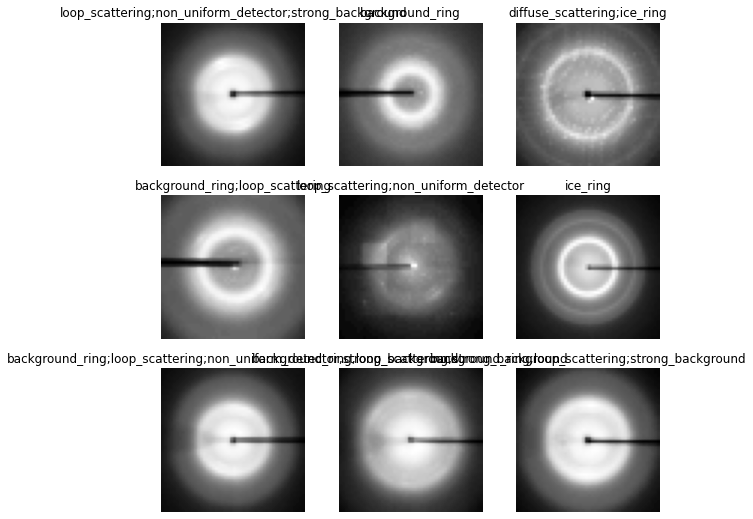

In [19]:
dataloaders.show_batch(max_n=9)

## Training

Now we use a pretrained *Resnet18* and use the train for this perticular dataset

> Note: We are using the pretrained Resnet18 via Transfer Learning, which basically means that we are using a model that is already trained for doing good at something else (which is to predict classes in ImageNet here) to do our task. This reduces the traning time.

In [20]:
learn = cnn_learner(dataloaders, resnet18, metrics=partial(accuracy_multi, thresh=0.5), cbs=WandbCallback())

`lr_find` is an useful functionality that is useful in finding optimal learning rqate for training. It outputs the graph and the two values onw which specifies the lr where the loss was at its least and other one at the steepest slope. The steepest slope is the interest for us for most of the cases

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.03981071710586548)

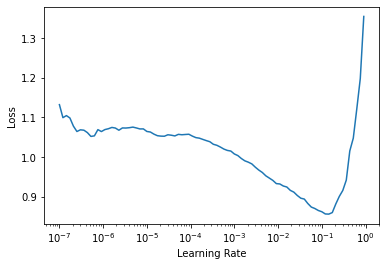

In [21]:
learn.lr_find()

`fine_tune` tunes the newly introduced layer for one epoch and *unfreeses* the previous layers for training for the later epochs. We would see two tables representing its loss and other metrics for the same reason 

In [22]:
learn.fine_tune(10, 4e-2)

wandb: Wandb version 0.8.34 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.495263,0.373240,0.831220,00:22


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.349745,0.311832,0.872538,00:23
1,0.338403,0.339598,0.850351,00:24
2,0.339028,0.308806,0.875481,00:23
3,0.318818,0.334795,0.861444,00:23
4,0.294721,0.269664,0.890424,00:22
5,0.254378,0.249635,0.901064,00:23
6,0.220228,0.236530,0.910233,00:23
7,0.177766,0.221808,0.916459,00:22
8,0.150120,0.213772,0.923251,00:22
9,0.131988,0.215067,0.923817,00:23


So, I tried running through various experiments. The code below helps in loading the previous saved model. I save models which have better accuracies and use it as a starting point for going further.

In [32]:
learn=learn.load(run_name+'.h5')

For this experiment I didnt change architecture much. I tried changing the image size and batch_size and learning_rate. Choosing the learning rate after initial training is little hard. Thanks to W&B I could see the learning rate for various epochs. I chose the lr which had the slopiest accuracy improvement at the end of the training and updated it

In [39]:
learn.fit_one_cycle(10,1e-6)

wandb: Wandb version 0.8.34 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.047517,0.220021,0.932194,00:22
1,0.048205,0.219809,0.931515,00:22
2,0.047783,0.223721,0.931062,00:22
3,0.047295,0.223825,0.929477,00:22
4,0.045167,0.222147,0.930383,00:22
5,0.043862,0.222521,0.931288,00:22
6,0.045675,0.222911,0.928911,00:22
7,0.044050,0.223413,0.929364,00:22
8,0.046282,0.224207,0.930722,00:23
9,0.045452,0.220096,0.930156,00:23


We would have to save the model for later inference

In [36]:
learn.save(run_name+'.h5')
wandb.save(run_name+'.h5')

[]

## Results

Of some of the experiments we did, we saw the results as follows:


| Run name | Image Size | Performance | Batch Size |
|----------|---|---------|--|
| Basic Resnet 16 | 224 | 0.941193 | Default |
| Basic Resnet 16 - 48 (256) | 48 | 0.926874 | 256 |
| Basic Resnet 16 - 48 (128) | 48 | 0.938307 | 128 |
| Basic Resnet 16 - 48 (64) | 48 | 0.936382 | 64 |
| Basic Resnet 16 - 48 (32) | 48 | 0.931741 | 32 |


### Which Model to choose:

Of some of the various experiments trained, we didnt include any of them when them were we used 3 channels as input simply because it gave the same result but occupying more weights for model anf might have slightly more time to train for infer.

> Note: One of the decision to take is between Run 1 and Run 3.

Run 1 has around 0.3% more accuracy than Run 3 but it uses bigger image. This means:
* Model of Run 1 is bigger than Run 3
* Run 1 might take more time to train or infer than Run 3

> Tip: If the usecase allows a slightly accurate model always prefer the smaller model

## Prediction

X-Ray images are less popular. So I am choosing a image from the validation set to check how it is predicting. To do so, first lets look at validation image.

In [55]:
learn.dls.valid_ds.items[['image','labels']]

,image,labels
3762,49967_1_E2_001,"background_ring, diffuse_scattering"
4146,9172_1_E1_001,"loop_scattering, background_ring, non_uniform_detector"
6190,ATPM1E10gly-peak.0001,"background_ring, non_uniform_detector"
1845,15533_1_E2_001,"loop_scattering, strong_background"
4903,r9_3.0001,background_ring
...,...,...
2584,120919_1_E1_001,"loop_scattering, strong_background"
2800,93400_1_E2_001,"loop_scattering, background_ring, non_uniform_detector"
1869,64132_2,"background_ring, diffuse_scattering"
2555,K16_ok2,


I am choosing the second one as a random image to test

In [64]:
learn.predict(path/'images/9172_1_E1_001.png')

((#3) ['background_ring','loop_scattering','non_uniform_detector'],
 tensor([False,  True, False, False,  True,  True, False]),
 tensor([6.4019e-03, 9.9865e-01, 3.6687e-02, 7.4511e-06, 9.9855e-01, 9.6328e-01,
         6.6407e-04]))

Here it provides the Predicted labels, The One Hot Encoding values infered and the actual tensor values of the model. 

We also see that this label prediction is indeed correct

## Conclusion

The Idea of this blog is to go through a simple Multi-Label Image Classifer. Though there are lots of other options that could have experimented with, simge the dataset was relatively simple and accuracy seem good enough, we leave them here. 

We can try a different dataset which demands more accuracy in a different blog post

Kindly let know your comments on the same